# Data Acquisition & Comparing Sources

>- Note: this is an updated/streamlined version of a prior repository `playing-with-coronavirus-data` [Link](https://github.com/jirvingphd/playing-with-coronavirus-data)

- 09/06/21

- The goal is this notebook is to find the best sources to combine for the following statistics about the coronavirus pandemic, at the state-level. 
- This notebook will also compare legacy data sources vs the updated sources before finally saving the data to be used for time-series forecasting in notebook #2

# Business Problem

- Covid-19 and the various strains that have since emerged has upended modern life and fundamental changed how we function as a society.
- Part of what has made it difficult to tackle the pandemic is due to differences between states, state laws/policies, and a lack of public understanding about the predictability of the surges in cases. 


## To Do: Add Intro/Full Business Case

### Imports & Setting File Destinations

In [1]:
# !pip install fsds
# !pip install pmdarima

from fsds.imports import *

import os,glob,sys,joblib,zipfile,json
import re

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

plt.rcParams['figure.figsize'] = (12,6)
pd.set_option('display.max_columns',0)

fsds v0.3.2 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


In [2]:
import statsmodels
print(f"Statsmodels version: {statsmodels.__version__}")

import pmdarima
print(f"pmdarima version: {pmdarima.__version__}")

Statsmodels version: 0.12.2
pmdarima version: 1.8.2


In [77]:
# ### FORECAST SPECIFIC FUNCTIONS
# import statsmodels.api as sms
# import statsmodels.tsa.api as tsa
# from pmdarima import auto_arima

In [4]:
## Custom Functions and Classes
%load_ext autoreload
%autoreload 2
import project_functions as fn

In [5]:
## Specifying data storage folders
fpath_raw = r"./data_raw/"
fpath_clean = r"./data/"
fpath_reference = r"./reference_data/"
[os.makedirs(fpath,exist_ok=True) for fpath in [fpath_clean,fpath_raw,fpath_reference]];

# The Data

## Original Data Source - The Covid Tracking Project

- As of 03/07/21 the Covid Tracking Project has stopped collecting new data. 
    - https://covidtracking.com/data
    - This was the primary backbone of my modeling and dashboard and needs to be replaced/ 
    - While I already have an alternative coronavirus source for time series from Kaggle, I want to have the ICU capacity and hospitalization records.
    
    
- Federal Data: 
    - Covid Tracking Project provides info on alternative data sources. https://covidtracking.com/analysis-updates/federal-covid-data-101-how-to-find-data
        - related posts: https://covidtracking.com/analysis-updates/category/federal-covid-data-101
    - They also provide a simple approach for the general public: https://covidtracking.com/analysis-updates/simple-covid-data

### Trainings Available from C.T.P

- COVID-19 hospitalization data training:
    - Video: https://www.youtube.com/watch?v=TGAHQt1Rkf8
    - Presentaation (my copy): https://docs.google.com/presentation/d/1p5XNS7b9_R40zaBgC5EiWvP1Vs7UJiAXPQ3WP-U9PjI/edit?usp=sharing

In [6]:
help(fn.data_acquisition.legacy)

Help on module project_functions.legacy_data_acquisition in project_functions:

NAME
    project_functions.legacy_data_acquisition

CLASSES
    builtins.object
        BaselineData
            CoronaData
            CovidTrackingProject
    
    class BaselineData(builtins.object)
     |  #Make a base class
     |  
     |  Methods defined here:
     |  
     |  __repr__(self)
     |      Return repr(self).
     |  
     |  __str__(self)
     |      Return str(self).
     |  
     |  get_group_ts(self, group_name, group_col='state', ts_col=None, df=None, freq='D', agg_func='sum')
     |      Take df_us and extracts state's data as then Freq/Aggregation provided
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  __dict__
     |      dictionary for instance variables (if defined)
     |  
     |  __weakref__
     |      list of weak references to the object (if defined)
     |  
     |  df
    
 

In [7]:
## original class for using The Covid Tracking Project API
covid = fn.data_acquisition.legacy.CovidTrackingProject(verbose=True)
covid

[i] DOWNLOADING DATASETS FROM COVID TRACKING PROJECT
	https://covidtracking.com/data
	- File saved as: "./data_legacy/states_metadata.csv"
ERROR
	- File saved as: "./data_legacy/us.csv"
	- File saved as: "./data_legacy/states.csv"
states


------------------------------------------------------------
[i] CovidTrackingProject Contents:
------------------------------------------------------------

METHODS:
	download_state_daily
	download_state_meta
	download_us_daily
	get_csv_save_load
	get_df
	get_group_ts
	help

ATTRIBUTES
	base_folder
	base_url
	columns
	columns_us
	df
	df_states
	df_us
	urls

In [8]:
df_prev = covid.df_us.copy()
df_prev

,positive,negative,death,recovered,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,states,pending,dateChecked,hash
date,,,,,,,,,,,,,,
2021-03-07,28756489.0,74582825.0,515151.0,NaN,40199.0,776361.0,8134.0,45475.0,2802.0,4281.0,56,11808.0,2021-03-07T24:00:00Z,a80d0063822e251249fd9a44730c49cb23defd83
2021-03-06,28714654.0,74450990.0,514309.0,NaN,41401.0,775635.0,8409.0,45453.0,2811.0,4280.0,56,11783.0,2021-03-06T24:00:00Z,dae5e558c24adb86686bbd58c08cce5f610b8bb0
2021-03-05,28654639.0,74307155.0,512629.0,NaN,42541.0,775132.0,8634.0,45373.0,2889.0,4275.0,56,12213.0,2021-03-05T24:00:00Z,724844c01659d0103801c57c0f72bf8cc8ab025c
2021-03-04,28585852.0,74035238.0,510408.0,NaN,44172.0,772351.0,8970.0,45293.0,2973.0,4267.0,56,12405.0,2021-03-04T24:00:00Z,5c549ad30f9abf48dc5de36d20fa707014be1ff3
2021-03-03,28520365.0,73857281.0,508665.0,NaN,45462.0,770821.0,9359.0,45214.0,3094.0,4260.0,56,11778.0,2021-03-03T24:00:00Z,fef6c425d2b773a9221fe353f13852f3e4a4bfb0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-17,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2020-01-17T24:00:00Z,5fd7ed7fb0f83565ea0aaaf5ff6104e5860be2d6
2020-01-16,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2020-01-16T24:00:00Z,4c0f2ea879eefec1a18a93bcd8a382ea56cd452d
2020-01-15,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2020-01-15T24:00:00Z,8a449023413eea473277416e9e30ae126c6af047


In [9]:
legacy_df = covid.df_states.copy()
legacy_df.index.name='Date'
legacy_state = legacy_df.groupby('state').get_group('NY').copy()
# old_md = old_md.set_index('date').sort_index()
legacy_state

,state,fips,positive,negative,death,recovered,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,pending,dataQualityGrade,lastUpdateEt,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,positiveIncrease,totalTestResults,totalTestResultsIncrease,deathIncrease,hospitalizedIncrease
Date,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-07,NY,36,1681169.0,NaN,39029.0,NaN,4789.0,NaN,999.0,NaN,682.0,NaN,NaN,NaN,3/6/2021 14:00,NaN,NaN,NaN,NaN,6789,39695100.0,227768,59,0
2021-03-06,NY,36,1674380.0,NaN,38970.0,NaN,4954.0,NaN,1012.0,NaN,694.0,NaN,NaN,NaN,3/5/2021 14:00,NaN,NaN,NaN,NaN,7647,39467332.0,273132,79,0
2021-03-05,NY,36,1666733.0,NaN,38891.0,NaN,5034.0,NaN,1030.0,NaN,700.0,NaN,NaN,NaN,3/4/2021 14:00,NaN,NaN,NaN,NaN,8956,39194200.0,296935,95,0
2021-03-04,NY,36,1657777.0,NaN,38796.0,NaN,5177.0,NaN,1043.0,NaN,712.0,NaN,NaN,NaN,3/3/2021 14:00,NaN,NaN,NaN,NaN,7593,38897265.0,270089,61,0
2021-03-03,NY,36,1650184.0,NaN,38735.0,NaN,5323.0,NaN,1047.0,NaN,735.0,NaN,NaN,NaN,3/2/2021 14:00,NaN,NaN,NaN,NaN,7704,38627176.0,218069,75,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-06,NY,36,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236.0,NaN,NaN,NaN,NaN,NaN,NaN,22,122.0,92,0,0
2020-03-05,NY,36,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,2,30.0,20,0,0
2020-03-04,NY,36,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,0,10.0,9,0,0


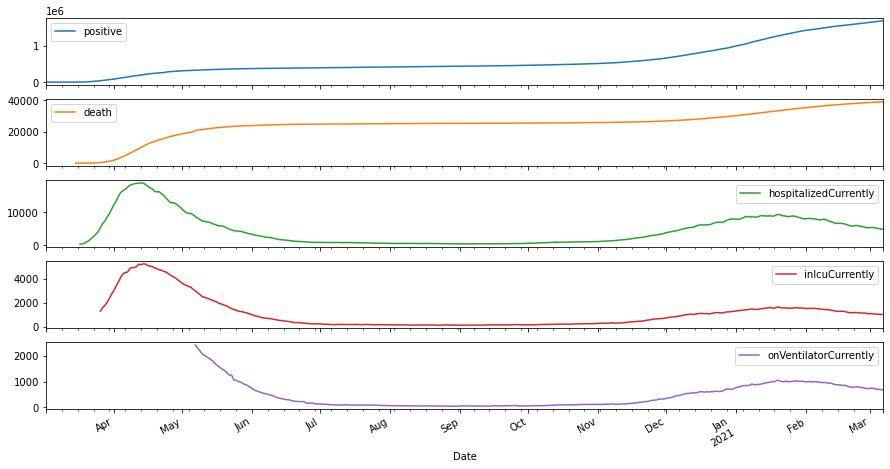

In [10]:
cols_used = ['positive','death','hospitalizedCurrently','inIcuCurrently',
            'onVentilatorCurrently']

legacy_state[cols_used].plot(figsize=(15,8),subplots=True);

## Finding New Data Sources

### Data to Acquire via New Sources
- The various metrics I want to combine per-state are:
    1. \# of Cases (Cumulative and Daily)
    2. \# of Deaths (Cumulative and Daily)
    3. \# Hospital Total Beds Used  (maybe %)
    4. \# Hospital ICU Beds Used (maybe %)
    5. \# of Ventillators Used

### New Sources Summary

#### Source for Coronavirus # of Cases & Deaths:

- Kaggle Dataset: "COVID-19 data from John Hopkins University" [Link](https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university)
    - API Command:  
    ```python 
!kaggle datasets download -p "{fpath_raw}" -d antgoldbloom/covid19-data-from-john-hopkins-university
```

- Comes with `CONVENIENT_` files and `RAW_` files. We will use:
    - `CONVENIENT_us_metadata.csv`

# Preprocessing

- Download up-to-date covid and hospital data. 
- Get all as daily frequency and with State Abbrevs before merging.
- Save in a dictionary/joblib

- Original Data Acquisition and Preprocessing Code is stored in:
    - `project_functions.data_acquisiton.legacy`

## Reference Data

- The data must be joined together using state-abbreviations/codes. Since these abbreviations are not in every data source, we must add them to each file.


### State Abbreviations

In [11]:
## Getting State Abbrevs
state_abbrevs = pd.read_csv('reference_data/united_states_abbreviations.csv')

## Making dicts of Name:Abbrev and Abbrev:Name
state_to_abbrevs_map = dict(zip(state_abbrevs['State'],state_abbrevs['Abbreviation']))
abbrev_to_state_map = dict(zip(state_abbrevs['Abbreviation'],state_abbrevs['State']))
state_to_abbrevs_map.keys()

dict_keys(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 'Puerto Rico'])

### World Populations

- Holdover from original analysis. 
- **Not yet added to this workflow**

In [12]:
world_pop = fn.data_acquisition.legacy.download_world_pop()
world_pop

Population data saved to ./reference_data/population-by-country-2020.zip


,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1440297825,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,India,1382345085,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,United States,331341050,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,Indonesia,274021604,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,Pakistan,221612785,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %
...,...,...,...,...,...,...,...,...,...,...,...
230,Montserrat,4993,0.06 %,3,50,100,NaN,N.A.,N.A.,10 %,0.00 %
231,Falkland Islands,3497,3.05 %,103,0,12170,NaN,N.A.,N.A.,66 %,0.00 %
232,Niue,1628,0.68 %,11,6,260,NaN,N.A.,N.A.,46 %,0.00 %
233,Tokelau,1360,1.27 %,17,136,10,NaN,N.A.,N.A.,0 %,0.00 %


## Covid-19 Data From Johns Hopkins University

- https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university


In [13]:
# # !pip install kaggle
# import kaggle

In [14]:
## Download kaggle jhu data and make zipfile object
# !kaggle datasets download -p "{fpath_raw}" -d antgoldbloom/covid19-data-from-john-hopkins-university
os.system(f'kaggle datasets download -p "{fpath_raw}" -d antgoldbloom/covid19-data-from-john-hopkins-university')
jhu_data_zip = zipfile.ZipFile(os.path.join(fpath_raw,'covid19-data-from-john-hopkins-university.zip'))
jhu_data_zip.namelist()

['CONVENIENT_global_confirmed_cases.csv',
 'CONVENIENT_global_deaths.csv',
 'CONVENIENT_global_metadata.csv',
 'CONVENIENT_us_confirmed_cases.csv',
 'CONVENIENT_us_deaths.csv',
 'CONVENIENT_us_metadata.csv',
 'RAW_global_confirmed_cases.csv',
 'RAW_global_deaths.csv',
 'RAW_us_confirmed_cases.csv',
 'RAW_us_deaths.csv']

### prep `df_metadata`

In [15]:
# prep df_metadata
file = 'CONVENIENT_us_metadata.csv'
jhu_data_zip.extract(file,path=fpath_raw)


df_metadata = pd.read_csv(os.path.join(fpath_raw,file))


## Adding State Abbrevas to kaggle metadata
df_metadata.insert(1,'State_Code',df_metadata['Province_State'].map(state_to_abbrevs_map))
print(df_metadata.isna().sum())

## Dropping us territories
df_metadata.dropna(subset=['State_Code'], inplace=True)

## Saving county info
df_metadata.to_csv(os.path.join(fpath_reference,"us_metadata_counties.csv"),index=False)
df_metadata

Province_State    0
State_Code        6
Admin2            6
Population        0
Lat               0
Long              0
dtype: int64


,Province_State,State_Code,Admin2,Population,Lat,Long
0,Alabama,AL,Autauga,55869,32.539527,-86.644082
1,Alabama,AL,Baldwin,223234,30.727750,-87.722071
2,Alabama,AL,Barbour,24686,31.868263,-85.387129
3,Alabama,AL,Bibb,22394,32.996421,-87.125115
4,Alabama,AL,Blount,57826,33.982109,-86.567906
...,...,...,...,...,...,...
3337,Wyoming,WY,Teton,23464,43.935225,-110.589080
3338,Wyoming,WY,Uinta,20226,41.287818,-110.547578
3339,Wyoming,WY,Unassigned,0,0.000000,0.000000
3340,Wyoming,WY,Washakie,7805,43.904516,-107.680187


In [16]:
## Saving a states-only version with aggregated populations and mean lat/long
df_state_metadata = df_metadata.groupby('Province_State',as_index=False).agg({'Population':'sum',
                                               "Lat":'mean',"Long":"mean"})
df_state_metadata.insert(1,'State_Code',df_state_metadata['Province_State'].map(state_to_abbrevs_map))
df_state_metadata.to_csv(os.path.join(fpath_reference,"us_metadata_states.csv"),index=False)
df_state_metadata

,Province_State,State_Code,Population,Lat,Long
0,Alabama,AL,4903185,31.931113,-84.196785
1,Alaska,AK,740995,56.628273,-139.571540
2,Arizona,AZ,7278717,29.714033,-98.349911
3,Arkansas,AR,3017804,34.005087,-90.033096
4,California,CA,39512223,36.582496,-116.704308
5,Colorado,CO,5758736,37.755612,-102.289687
6,Connecticut,CT,3565287,33.290944,-58.125464
7,Delaware,DE,973764,23.465566,-45.319942
8,District of Columbia,DC,705749,12.968059,-25.672187
9,Florida,FL,21477737,28.101892,-80.303621


In [17]:
## Making and saving remapping dicts
import joblib

state_to_abbrevs_meta = dict(zip(df_state_metadata['Province_State'],df_state_metadata['State_Code']))
abbrev_to_state_meta = dict(zip(df_state_metadata['State_Code'],df_state_metadata['Province_State']))

joblib.dump(state_to_abbrevs_meta, os.path.join(fpath_reference,'state_names_to_codes_map.joblib'))
joblib.dump(abbrev_to_state_meta, os.path.join(fpath_reference,'state_codes_to_names_map.joblib'))

## save mapper fo state to code for function
mapper_path = os.path.join(fpath_reference,'state_names_to_codes_map.joblib')
mapper_path

'./reference_data/state_names_to_codes_map.joblib'

### Use `fn.data_acquisition` functions to preprocess data

In [18]:
## Prep ` df_cases_ts`
df_cases = fn.data_acquisition.load_raw_ts_file(jhu_data_zip,fpath_raw,
                                                file = 'RAW_us_confirmed_cases.csv',)
df_cases_ts = fn.data_acquisition.melt_df_to_ts(df_cases,'Cases')
df_cases_ts

- Loading data from RAW_us_confirmed_cases.csv


Province_State          Admin2  Cases
State_Code Date                                            
AK         2020-01-22         Alaska  Aleutians East      0
           2020-01-22         Alaska  Aleutians West      0
           2020-01-22         Alaska       Anchorage      0
           2020-01-22         Alaska          Bethel      0
           2020-01-22         Alaska     Bristol Bay      0
...                              ...             ...    ...
WY         2021-09-05        Wyoming           Teton   4502
           2021-09-05        Wyoming           Uinta   3053
           2021-09-05        Wyoming      Unassigned      0
           2021-09-05        Wyoming        Washakie   1080
           2021-09-05        Wyoming          Weston    802

[1978248 rows x 3 columns]

In [19]:
## Prep df_deaths_ts
df_deaths = fn.data_acquisition.load_raw_ts_file(jhu_data_zip,fpath_raw,file = 'RAW_us_deaths.csv')
df_deaths_ts = fn.data_acquisition.melt_df_to_ts(df_deaths,'Deaths')
df_deaths_ts

- Loading data from RAW_us_deaths.csv


Province_State          Admin2  Deaths
State_Code Date                                             
AK         2020-01-22         Alaska  Aleutians East       0
           2020-01-22         Alaska  Aleutians West       0
           2020-01-22         Alaska       Anchorage       0
           2020-01-22         Alaska          Bethel       0
           2020-01-22         Alaska     Bristol Bay       0
...                              ...             ...     ...
WY         2021-09-05        Wyoming           Teton      11
           2021-09-05        Wyoming           Uinta      15
           2021-09-05        Wyoming      Unassigned       0
           2021-09-05        Wyoming        Washakie      27
           2021-09-05        Wyoming          Weston       6

[1978248 rows x 3 columns]

### pd.merge for `df_cases_deaths_ts`

In [20]:
## Merge df_cases_ts and df_deaths_ts
df_cases_deaths_ts = pd.merge(df_cases_ts.reset_index(), df_deaths_ts.reset_index())
df_cases_deaths_ts

,State_Code,Date,Province_State,Admin2,Cases,Deaths
0,AK,2020-01-22,Alaska,Aleutians East,0,0
1,AK,2020-01-22,Alaska,Aleutians West,0,0
2,AK,2020-01-22,Alaska,Anchorage,0,0
3,AK,2020-01-22,Alaska,Bethel,0,0
4,AK,2020-01-22,Alaska,Bristol Bay,0,0
...,...,...,...,...,...,...
1978243,WY,2021-09-05,Wyoming,Teton,4502,11
1978244,WY,2021-09-05,Wyoming,Uinta,3053,15
1978245,WY,2021-09-05,Wyoming,Unassigned,0,0
1978246,WY,2021-09-05,Wyoming,Washakie,1080,27


#### Saving df_cases_deaths_ts `'us_states_cases_deaths.csv'`

In [21]:
df_cases_deaths_ts.to_csv(os.path.join(fpath_clean,'us_states_cases_deaths.csv'),index=True)

### Making & saving  "`df_daily_cases_deaths_ts`"

In [22]:
df_daily_cases_deaths_ts = df_cases_deaths_ts.set_index('Date')\
                                .groupby('State_Code').resample("D")\
                                    .sum().reset_index()
df_daily_cases_deaths_ts.to_csv(os.path.join(fpath_clean,'us_states_daily_cases_deaths.csv'),index=True)
df_daily_cases_deaths_ts

,State_Code,Date,Cases,Deaths
0,AK,2020-01-22,0,0
1,AK,2020-01-23,0,0
2,AK,2020-01-24,0,0
3,AK,2020-01-25,0,0
4,AK,2020-01-26,0,0
...,...,...,...,...
30831,WY,2021-09-01,76007,858
30832,WY,2021-09-02,76602,858
30833,WY,2021-09-03,77206,858
30834,WY,2021-09-04,77206,858


### `"COVID-19 Reported Patient Impact and Hospital Capacity by State Timeseries API"`
- https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh

- API URL (csv): https://healthdata.gov/resource/g62h-syeh.csv
- ~~geojson url: https://healthdata.gov/resource/g62h-syeh.geojson~~

In [23]:
fs.ihelp(fn.data_acquisition.get_hospital_data)

------------------------------------------------------------------------------------
------ SOURCE ----------------------------------------------------------------------


```python
def get_hospital_data(verbose=False):
    offset = 0
    ## Getting Hospital Capacity Data
    base_url = 'https://healthdata.gov/resource/g62h-syeh.csv'
    page = 0
    results = []
    print(f"[i] Retrieving hospital data from {base_url}")

    ## seting random, large page-len
    page_len = 1000

    while (page_len>0):
        try:
            if verbose:
                print(f"   - Page {page} (offset = {offset})")
            url = base_url+f"?$offset={offset}"
            df_temp = pd.read_csv(url)
            results.append(df_temp)

            page_len = len(df_temp)
            offset+=page_len
            page+=1
        except Exception as e:
            print('[!] ERROR:')
            print(e)
            print('-- returning raw results list instead of dataframe..')
            return results
        
    return pd.concat(results)

```

In [24]:
df1 = fn.data_acquisition.get_hospital_data()
df1 = df1.rename({'state':'State_Code',
                 'date':'Date'},axis=1)
df1['Date'] = pd.to_datetime(df1['Date'])
df1 = df1.sort_values(['State_Code','Date'])
df1

[i] Retrieving hospital data from https://healthdata.gov/resource/g62h-syeh.csv


,State_Code,Date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,inpatient_beds,inpatient_beds_coverage,inpatient_beds_used,inpatient_beds_used_coverage,inpatient_beds_used_covid,inpatient_beds_used_covid_coverage,previous_day_admission_adult_covid_confirmed,previous_day_admission_adult_covid_confirmed_coverage,previous_day_admission_adult_covid_suspected,previous_day_admission_adult_covid_suspected_coverage,previous_day_admission_pediatric_covid_confirmed,previous_day_admission_pediatric_covid_confirmed_coverage,previous_day_admission_pediatric_covid_suspected,previous_day_admission_pediatric_covid_suspected_coverage,staffed_adult_icu_bed_occupancy,staffed_adult_icu_bed_occupancy_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid,staffed_icu_adult_patients_confirmed_and_suspected_covid_coverage,staffed_icu_adult_patients_confirmed_covid,staffed_icu_adult_patients_confirmed_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_adult_patients_hospitalized_confirmed_covid,total_adult_patients_hospitalized_confirmed_covid_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_pediatric_patients_hospitalized_confirmed_covid,total_pediatric_patients_hospitalized_confirmed_covid_coverage,total_staffed_adult_icu_beds,total_staffed_adult_icu_beds_coverage,inpatient_beds_utilization,inpatient_beds_utilization_coverage,inpatient_beds_utilization_numerator,inpatient_beds_utilization_denominator,percent_of_inpatients_with_covid,percent_of_inpatients_with_covid_coverage,percent_of_inpatients_with_covid_numerator,percent_of_inpatients_with_covid_denominator,inpatient_bed_covid_utilization,inpatient_bed_covid_utilization_coverage,inpatient_bed_covid_utilization_numerator,inpatient_bed_covid_utilization_denominator,adult_icu_bed_covid_utilization,adult_icu_bed_covid_utilization_coverage,adult_icu_bed_covid_utilization_numerator,adult_icu_bed_covid_utilization_denominator,adult_icu_bed_utilization,adult_icu_bed_utilization_coverage,adult_icu_bed_utilization_numerator,adult_icu_bed_utilization_denominator,geocoded_state,previous_day_admission_adult_covid_confirmed_18_19,previous_day_admission_adult_covid_confirmed_18_19_coverage,previous_day_admission_adult_covid_confirmed_20_29,previous_day_admission_adult_covid_confirmed_20_29_coverage,previous_day_admission_adult_covid_confirmed_30_39,previous_day_admission_adult_covid_confirmed_30_39_coverage,previous_day_admission_adult_covid_confirmed_40_49,previous_day_admission_adult_covid_confirmed_40_49_coverage,previous_day_admission_adult_covid_confirmed_50_59,previous_day_admission_adult_covid_confirmed_50_59_coverage,previous_day_admission_adult_covid_confirmed_60_69,previous_day_admission_adult_covid_confirmed_60_69_coverage,previous_day_admission_adult_covid_confirmed_70_79,previous_day_admission_adult_covid_confirmed_70_79_coverage,previous_day_admission_adult_covid_confirmed_80,previous_day_admission_adult_covid_confirmed_80_coverage,previous_day_admission_adult_covid_confirmed_unknown,previous_day_admission_adult_covid_confirmed_unknown_coverage,previous_day_admission_adult_covid_suspected_18_19,previous_day_admission_adult_covid_suspected_18_19_coverage,previous_day_admission_adult_covid_suspected_20_29,previous_day_admission_adult_covid_suspected_20_29_coverage,previous_day_admission_adult_covid_suspected_30_39,previous_day_admission_adult_covid_suspected_30_39_coverage,previous_day_admission_adult_covid_suspected_40_49,previous_day_admission_adult_covid_suspected_40_49_coverage,pr

#### [Column Notes](https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh)
- General Naming Schemes:
    - "...coverage" columns:
        - coverage columns seem to all represent # of hospitals reporting for that stat. 
    - "...utilization" columns:
        - seem to be the metrics I am looking for
            - have "utilization",+'_denominator'+'numerator" columns for each
    
    
    
- Groups of columns:
    - "critical_staffing_shortage" columns:
        - "critical_staffing_shortage_today"...
            - yes, no, not_reported
        - "critical_staffing_anticipated_within_week"....
            - yes,no,not_reported
    - "hospital_onset"...
    - "inpatient_beds"...
    - "previous_day_admission"..
        

### Saving Columns

- Custom Class that inherits from a dictionary with additional methods for sifting through column names and storing good/bad columns as attributes

In [25]:
fs.ihelp(fn.data_acquisition.ColumnDict)

------------------------------------------------------------------------------------
------ SOURCE ----------------------------------------------------------------------


```python
class ColumnDict(dict):
    """Inherits from a normal dictionary.
    
    Methods:
        find_expr_cols: methods for finding columns based on expressions
                        saves the column names under with the expression  as key
        get_all_values: gets list of all unique values stored in dict
    Adds 
    Also saved keep_keys True/False dict of expressions that should be kept or dropped
    """
    keep_keys = {True:list(),False:list(),'id':list()} # Expressions 
    keep_cols = {True:list(),False:list()} # column names
    
    def __init__(self, id_cols=[],*args,**kwargs):

        self.id_cols=id_cols
        ## Empty list of keep keys/cols
#         self['id'] = self.id_cols
        self.keep_keys = {True:list(),False:list(),'id':self.id_cols} # Expressions 
        self.keep_cols = {True:[*self.id_cols],False:list()} # column names
    #     id_cols = list() ## id columns to be auto-kept 
        super().__init__(*args,**kwargs)
    

    
    def get_all_values(self,keep=None):
        """Retrieves list of unique column names:
        Args:
            keep (None, True, False): determines subset of columns returned
            # Adapter from: https://www.geeksforgeeks.org/python-concatenate-dictionary-value-lists/
            """
        if keep is None:
            from itertools import chain
            return [*self.id_cols,*set(list(chain(*self.values())))]
        
        elif keep==True:
            col_list = list(set(self.keep_cols[keep]))
            return [*self.id_cols, *[c for c in col_list if c not in self.id_cols]]
#             return list(set([*self.id_cols,*]))
        elif keep==False:
            return list(set(self.keep_cols[keep]))

        
        
    def find_expr_cols(self,expressions,df,keep,exlcude_known_cols=None):
        """Saves lists of column names as values in dict
        Args:
            Expresssions (str,list): patterns to find in column names 
            df (DataFrame): dataframe to check
            keep (bool): saves expr and cols keep_cols/keep_keys as True or False
            
        TO DO:
            exlcude_known_cols (NOT IMPLEMENTED YET): will check if found columns 
                                are already in any of the known lists of cols
                                
                                
                                
        EXAMPLE USAAGE:
        >>> COLUMNS = ColumnDict()
        >>> COLUMNS.find_expr_cols(['staffing','previous_day','coverage'],
                                    df1,keep=False)
        """
            
        if isinstance(expressions,str):
                expressions = [expressions]
                
        for expr in expressions:
            found_cols = [c for c in df.columns if expr in c]
            self[expr] = found_cols

            ## Save exression and fond_cols to keep_keys/keep_cols
            self.keep_keys[keep].append(expr)
            
            [self.keep_cols[keep].append(c) for c in found_cols if c not in self.keep_cols[keep]]

```

In [26]:
#### SIFT THROUGH COLUMNS
COLUMNS = fn.data_acquisition.ColumnDict(id_cols=['State_Code','Date'])

## saving names to DROP to COLUMNS dict
drop_col_expressions = ['staff','previous_day','coverage','onset']
COLUMNS.find_expr_cols(drop_col_expressions,df1,keep=False)


## saving names to KEEP to COLUMNS dict
keep_col_expressions = ['inpatient_bed','adult_icu_bed','utilization',
                        'total_adult_patients','total_pediatric_patients',
                    'percent_of_inpatients_with_covid','deaths']
COLUMNS.find_expr_cols(keep_col_expressions,df1,keep=True)


## view methods/attributes
[a for a in dir(COLUMNS) if not a.startswith('__')]

['clear',
 'copy',
 'find_expr_cols',
 'fromkeys',
 'get',
 'get_all_values',
 'id_cols',
 'items',
 'keep_cols',
 'keep_keys',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [27]:
## Making df_hospitals
df_hospitals = df1[COLUMNS.get_all_values(keep=True)].copy()
df_hospitals = df_hospitals.set_index(COLUMNS.id_cols).sort_index()
df_hospitals.reset_index().to_csv(os.path.join(fpath_raw,'hospital_data.csv'))

df_hospitals#.loc['MD',['inpatient_beds_utilization']].plot()

total_staffed_adult_icu_beds staffed_adult_icu_bed_occupancy_coverage  ...  deaths_covid  total_pediatric_patients_hospitalized_confirmed_and_suspected_covid
State_Code Date                                                                               ...                                                                                   
AK         2020-03-23                           NaN                                        0  ...           0.0                                                NaN                  
           2020-03-24                           NaN                                        0  ...           0.0                                                NaN                  
           2020-03-25                           NaN                                        0  ...           0.0                                                NaN                  
           2020-03-26                           NaN                                        0  ...           0.0                                                NaN                  
           2020-03-27                           NaN                                        0  ...           0.0                                                NaN                  
...                                             ...                                      ...  ...           ...                                                ...                  
WY         2021-09-02                         137.0                                       31  ...           2.0                                                2.0                  
           2021-09-03                         137.0                                       31  ...           4.0                                                1.0                  
           2021-09-04                         137.0                                       31  ...           3.0                                                1.0                  
           2021-09-05                         138.0                                       31  ...           1.0                                                1.0                  
           2021-09-06                         138.0                                       29  ...           1.0                                                1.0                  

[29657 rows x 40 columns]

In [28]:
joblib.dump(COLUMNS,os.path.join(fpath_clean,'COLUMNS.joblib'))

['./data/COLUMNS.joblib']

### Combine All Data

In [29]:
 #### combine all data
df = pd.merge(df_daily_cases_deaths_ts,df_hospitals.reset_index())
df

,State_Code,Date,Cases,Deaths,total_staffed_adult_icu_beds,staffed_adult_icu_bed_occupancy_coverage,inpatient_beds,adult_icu_bed_utilization,total_adult_patients_hospitalized_confirmed_covid_coverage,inpatient_beds_coverage,total_pediatric_patients_hospitalized_confirmed_covid,deaths_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid,percent_of_inpatients_with_covid,inpatient_beds_utilization_numerator,inpatient_beds_used_covid,adult_icu_bed_covid_utilization_coverage,staffed_adult_icu_bed_occupancy,adult_icu_bed_utilization_denominator,total_staffed_adult_icu_beds_coverage,percent_of_inpatients_with_covid_denominator,adult_icu_bed_utilization_coverage,inpatient_bed_covid_utilization,inpatient_beds_utilization,total_adult_patients_hospitalized_confirmed_covid,adult_icu_bed_covid_utilization,adult_icu_bed_covid_utilization_denominator,inpatient_beds_used_coverage,inpatient_bed_covid_utilization_numerator,inpatient_bed_covid_utilization_denominator,inpatient_beds_used,percent_of_inpatients_with_covid_numerator,adult_icu_bed_utilization_numerator,adult_icu_bed_covid_utilization_numerator,inpatient_bed_covid_utilization_coverage,total_pediatric_patients_hospitalized_confirmed_covid_coverage,inpatient_beds_utilization_denominator,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,percent_of_inpatients_with_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,inpatient_beds_utilization_coverage,inpatient_beds_used_covid_coverage,deaths_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid
0,AK,2020-03-23,39,0,NaN,0,56.0,NaN,0,1,NaN,1,NaN,0.142857,21.0,3.0,NaN,NaN,NaN,0,21.0,NaN,0.053571,0.375000,NaN,NaN,NaN,1,3.0,56.0,21.0,3.0,NaN,NaN,1.0,0,56.0,0,1.0,0,1.0,1,0.0,NaN
1,AK,2020-03-24,43,0,NaN,0,56.0,NaN,0,1,NaN,1,NaN,0.150000,20.0,3.0,NaN,NaN,NaN,0,20.0,NaN,0.053571,0.357143,NaN,NaN,NaN,1,3.0,56.0,20.0,3.0,NaN,NaN,1.0,0,56.0,0,1.0,0,1.0,1,0.0,NaN
2,AK,2020-03-25,50,1,NaN,0,56.0,NaN,0,1,NaN,1,NaN,0.066667,15.0,1.0,NaN,NaN,NaN,0,15.0,NaN,0.017857,0.267857,NaN,NaN,NaN,1,1.0,56.0,15.0,1.0,NaN,NaN,1.0,0,56.0,0,1.0,0,1.0,1,0.0,NaN
3,AK,2020-03-26,64,1,NaN,0,56.0,NaN,0,1,NaN,1,NaN,0.125000,16.0,2.0,NaN,NaN,NaN,0,16.0,NaN,0.035714,0.285714,NaN,NaN,NaN,1,2.0,56.0,16.0,2.0,NaN,NaN,1.0,0,56.0,0,1.0,0,1.0,1,0.0,NaN
4,AK,2020-03-27,75,1,NaN,0,81.0,NaN,0,2,NaN,2,NaN,0.043478,23.0,1.0,NaN,NaN,NaN,0,23.0,NaN,0.012346,0.283951,NaN,NaN,NaN,2,1.0,81.0,23.0,1.0,NaN,NaN,2.0,0,81.0,0,2.0,0,2.0,2,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28883,WY,2021-09-01,76007,858,137.0,31,1731.0,0.649635,31,31,1.0,29,202.0,0.229821,912.0,205.0,29.0,89.0,137.0,31,892.0,31.0,0.120944,0.526863,201.0,0.435115,131.0,31,205.0,1695.0,912.0,205.0,89.0,57.0,29.0,29,1731.0,29,29.0,29,31.0,29,0.0,3.0
28884,WY,2021-09-02,76602,858,137.0,31,1731.0,0.591241,31,31,1.0,29,204.0,0.243499,859.0,206.0,29.0,81.0,137.0,31,846.0,31.0,0.121534,0.496245,201.0,0.412214,131.0,31,206.0,1695.0,859.0,206.0,81.0,54.0,29.0,29,1731.0,29,29.0,29,31.0,29,2.0,2.0
28885,WY,2021-09-03,77206,858,137.0,31,1731.0,0.620438,31,31,0.0,29,195.0,0.232779,856.0,196.0,29.0,85.0,137.0,31,842.0,31.0,0.115634,0.494512,188.0,0.435115,131.0,31,196.0,1695.0,856.0,196.0,85.0,57.0,29.0,29,1731.0,29,29.0,29,31.0,29,4.0,1.0
28886,WY,2021-09-04,77206,858,137.0,31,1731.0,0.620438,31,31,0.0,29,199.0,0.246002,831.0,200.0,29.0,85.0,137.0,31,813.0,31.0,0.117994,0.480069,196.0,0.465649,131.0,31,200.0,1695.0,831.0,200.0,85.0,61.0,29.0,29,1731.0,29,29.0,29,31.0,29,3.0,1.0


In [30]:
df.to_csv(os.path.join(fpath_clean,'combined_us_states_full_data.csv'),index=False)


### Processing State Data

In [31]:
save_state_csvs = False

In [32]:
## Saving State CSVs
fpath_state_data = os.path.join(fpath_clean,'state_data/')
os.makedirs(fpath_state_data,exist_ok=True)


## make STATES dict
unique_states = df['State_Code'].unique()
df_states = df.set_index(['State_Code','Date']).sort_index()

STATES = {}
for state in unique_states:    
    df_state = df_states.loc[state].copy()
    if save_state_csvs:
        df_state.to_csv(f"{fpath_state_data}combined_data_{state}.csv.gz",compression='gzip')   
    STATES[state] = df_state.copy()

STATES.keys()

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

In [33]:
joblib.dump(STATES,os.path.join(fpath_clean,'STATE_DICT.joblib'))

['./data/STATE_DICT.joblib']

# Full Workflow - FUNCTIONIZED

In [34]:
## Boolean arg to control data acquisition
RUN_FULL_WORKFLOW = True

In [35]:
fs.ihelp(fn.data_acquisition.FULL_WORKFLOW)

------------------------------------------------------------------------------------
------ SOURCE ----------------------------------------------------------------------


```python
def FULL_WORKFLOW(save_state_csvs=False,fpath_raw = r"./data_raw/",
                  fpath_clean = r"./data/", fpath_reference = r"./reference_data/"):
    """Run entire data acquisiton process

    Returns:
        df_states (Frame): combined dataframe of all state data 
        STATES (dict): dict of individual state data
    """
    
    start = dt.datetime.now()
    
    print(f"========= RUNNING FULL WORKFLOW =========")
    ## Specifying data storage folders
    # fpath_raw = r"./data_raw/"
    # fpath_clean = r"./data/"
    # [os.makedirs(fpath,exist_ok=True) for fpath in [fpath_clean,fpath_raw]]
    [os.makedirs(fpath,exist_ok=True) for fpath in [fpath_clean,fpath_raw,fpath_reference]];

    print("[i] Retrieving kaggle dataset: antgoldbloom/covid19-data-from-john-hopkins-university")
    ## Download kaggle jhu data and make zipfile object
    os.system(f'kaggle datasets download -p "{fpath_raw}" -d antgoldbloom/covid19-data-from-john-hopkins-university')
    jhu_data_zip = zipfile.ZipFile(os.path.join(fpath_raw,'covid19-data-from-john-hopkins-university.zip'))


    ## Getting State Abbrevs
    state_abbrevs = pd.read_csv(os.path.join(fpath_reference,'united_states_abbreviations.csv'))

    ## Making dicts of Name:Abbrev and Abbrev:Name
    state_to_abbrevs_map = dict(zip(state_abbrevs['State'],state_abbrevs['Abbreviation']))
    abbrev_to_state_map = dict(zip(state_abbrevs['Abbreviation'],state_abbrevs['State']))
    # state_to_abbrevs_map


    # prep df_metadata
    file = 'CONVENIENT_us_metadata.csv'
    jhu_data_zip.extract(file,path=fpath_raw)
    df_metadata = pd.read_csv(os.path.join(fpath_raw,file))

    ## Adding State Abbrevas to kaggle metadata
    df_metadata.insert(1,'State_Code',df_metadata['Province_State'].map(state_to_abbrevs_map))
    # print(df_metadata.isna().sum())

    ## Dropping us territories
    df_metadata.dropna(subset=['State_Code'], inplace=True)

    ## Saving county info
    df_metadata.to_csv(os.path.join(fpath_reference,"us_metadata_counties.csv"),index=False)


    ## Saving a states-only version with aggregated populations and mean lat/long
    df_state_metadata = df_metadata.groupby('Province_State',as_index=False).agg({'Population':'sum',
                                                "Lat":'mean',"Long":"mean"})
    df_state_metadata.insert(1,'State_Code',df_state_metadata['Province_State'].map(state_to_abbrevs_map))
    df_state_metadata.to_csv(os.path.join(fpath_reference,"us_metadata_states.csv"),index=False)


    ## Making and saving remapping dicts

    state_to_abbrevs_meta = dict(zip(df_state_metadata['Province_State'],df_state_metadata['State_Code']))
    abbrev_to_state_meta = dict(zip(df_state_metadata['State_Code'],df_state_metadata['Province_State']))

    joblib.dump(state_to_abbrevs_meta, os.path.join(fpath_reference,'state_names_to_codes_map.joblib'))
    joblib.dump(abbrev_to_state_meta, os.path.join(fpath_reference,'state_codes_to_names_map.joblib'))

    ## save mapper fo state to code for function
    mapper_path = os.path.join(fpath_reference,'state_names_to_codes_map.joblib')
    mapper_path
    
    
    ## Prep ` df_cases_ts`
    df_cases = load_raw_ts_file(jhu_data_zip, save_fpath=fpath_raw, file = 'RAW_us_confirmed_cases.csv',)
    df_cases_ts = melt_df_to_ts(df_cases,'Cases')
    df_cases_ts
    
    
    ## Prep df_deaths_ts
    df_deaths = load_raw_ts_file(jhu_data_zip,save_fpath=fpath_raw,file = 'RAW_us_deaths.csv')
    df_deaths_ts = melt_df_to_ts(df_deaths,'Deaths')

    ## Merge df_cases_ts and df_deaths_ts
    df_cases_deaths_ts = pd.merge(df_cases_ts.reset_index(), df_deaths_ts.reset_index())
    df_cases_deaths_ts

    df_cases_deaths_ts.to_csv(os.path.join(fpath_clean,'us_states_cases_deaths.csv'),index=True)

    ## Resample to Daily State Data
    df_daily_cases_deaths_ts = df_cases_deaths_ts.set_index('Date')\
                                .groupby('State_Code').resample("D")\
                                    .sum().reset_index()
    df_daily_cases_deaths_ts.to_csv(os.path.join(fpath_clean,'us_states_daily_cases_deaths.csv'),index=True)
    df_daily_cases_deaths_ts
    
    ##### HOSPITAL DATA
    ## Get hispital Data
    df1 = get_hospital_data()
    df1 = df1.rename({'state':'State_Code',
                     'date':'Date'},axis=1)
    df1['Date'] = pd.to_datetime(df1['Date'])
    df1 = df1.sort_values(['State_Code','Date'])
    
    #### SIFT THROUGH COLUMNS
    COLUMNS = ColumnDict(id_cols=['State_Code','Date'])

    ## saving names to DROP to COLUMNS dict
    drop_col_expressions = ['staff','previous_day','coverage','onset']
    COLUMNS.find_expr_cols(drop_col_expressions,df1,keep=False)


    ## saving names to KEEP to COLUMNS dict
    keep_col_expressions = ['inpatient_bed','adult_icu_bed','utilization',
                            'total_adult_patients','total_pediatric_patients',
                        'percent_of_inpatients_with_covid','deaths']
    COLUMNS.find_expr_cols(keep_col_expressions,df1,keep=True)


    ## Making df_hospitals
    df_hospitals = df1[COLUMNS.get_all_values(keep=True)].copy()
    df_hospitals = df_hospitals.set_index(COLUMNS.id_cols).sort_index()
    df_hospitals.reset_index().to_csv(os.path.join(fpath_raw,'hospital_data.csv'))

    df_hospitals#.loc['MD',['inpatient_beds_utilization']].plot()
    joblib.dump(COLUMNS,os.path.join(fpath_reference,'COLUMNS.joblib'))
    
    #### combine all data
    df = pd.merge(df_daily_cases_deaths_ts,df_hospitals.reset_index())
    df.to_csv(os.path.join(fpath_clean,'combined_us_states_full_data.csv'),index=False)
    df
    
    
    ## Saving State CSVs
    if save_state_csvs:
        DATA_FOLDER = os.path.join(fpath_clean,'state_data/')
        os.makedirs(DATA_FOLDER,exist_ok=True)

    ## make STATES dict
    unique_states = df['State_Code'].unique()
    df_states = df.set_index(['State_Code','Date']).sort_index()

    STATES = {}
    for state in unique_states:    
        df_state = df_states.loc[state].copy()
        if save_state_csvs:
            df_state.to_csv(f"{DATA_FOLDER}combined_data_{state}.csv.gz",compression='gzip')   
        STATES[state] = df_state.copy()


    joblib.dump(STATES,os.path.join(fpath_clean,'STATE_DICT.joblib'))
    
    end = dt.datetime.now()
    print('[i] Workflow completed.')
    print(f'\tRun time={end-start} sec.')
    print('[i]The final files of note:')
    print(f"\t{os.path.join(fpath_clean,'combined_us_states_full_data.csv')}")
    print(f"\t{os.path.join(fpath_clean,'STATE_DICT.joblib')}")
    
    return df_states, STATES

```

In [36]:
## Uncomment Cell to acquire new data
if RUN_FULL_WORKFLOW:
    df_states,STATES = fn.data.FULL_WORKFLOW()
else:
    print(f"[i] Using previously downloaded data...")
    df_states = pd.read_csv(os.path.join(fpath_clean,
                                         'combined_us_states_full_data.csv'))
    STATES = joblib.load(os.path.join(fpath_clean,'STATE_DICT.joblib'))

display(df_states.head())
STATES.keys()

========= RUNNING FULL WORKFLOW =========
[i] Retrieving kaggle dataset: antgoldbloom/covid19-data-from-john-hopkins-university
- Loading data from RAW_us_confirmed_cases.csv
- Loading data from RAW_us_deaths.csv
[i] Retrieving hospital data from https://healthdata.gov/resource/g62h-syeh.csv
[i] Workflow completed.
	Run time=0:00:41.812589 sec.
[i]The final files of note:
	./data/combined_us_states_full_data.csv
	./data/STATE_DICT.joblib


Cases  Deaths  ...  deaths_covid total_pediatric_patients_hospitalized_confirmed_and_suspected_covid
State_Code Date                       ...                                                                                  
AK         2020-03-23     39       0  ...           0.0                                                NaN                 
           2020-03-24     43       0  ...           0.0                                                NaN                 
           2020-03-25     50       1  ...           0.0                                                NaN                 
           2020-03-26     64       1  ...           0.0                                                NaN                 
           2020-03-27     75       1  ...           0.0                                                NaN                 

[5 rows x 42 columns]

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

# Merging State Data with Hospital Data

In [37]:
# raise Exception('Updated up to here.')

# EDA

## Matching Hospital columns

#### Columns to find from the covid tracking project dataset: 

- "hospitalizedCurrently"/"hospitalizedCumulative"
- "inIcuCurrently","inIcuCumulative"
- "onVentilatorCurrently","onVentilatorCumulative"

In [38]:
## selected NY as comparison since it had ventillator data
compare_state='NY'

In [39]:
## OLD DATA
covid = fn.data_acquisition.legacy.CovidTrackingProject(verbose=True)
# covid

old_df = covid.df_states.copy()
old_df.index.name='Date'
old_state = old_df.groupby('state').get_group(compare_state).copy()
# old_md = old_md.set_index('date').sort_index()
old_state

[i] DOWNLOADING DATASETS FROM COVID TRACKING PROJECT
	https://covidtracking.com/data
	- File saved as: "./data_legacy/states_metadata.csv"
ERROR
	- File saved as: "./data_legacy/us.csv"
	- File saved as: "./data_legacy/states.csv"


,state,fips,positive,negative,death,recovered,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,pending,dataQualityGrade,lastUpdateEt,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,positiveIncrease,totalTestResults,totalTestResultsIncrease,deathIncrease,hospitalizedIncrease
Date,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-07,NY,36,1681169.0,NaN,39029.0,NaN,4789.0,NaN,999.0,NaN,682.0,NaN,NaN,NaN,3/6/2021 14:00,NaN,NaN,NaN,NaN,6789,39695100.0,227768,59,0
2021-03-06,NY,36,1674380.0,NaN,38970.0,NaN,4954.0,NaN,1012.0,NaN,694.0,NaN,NaN,NaN,3/5/2021 14:00,NaN,NaN,NaN,NaN,7647,39467332.0,273132,79,0
2021-03-05,NY,36,1666733.0,NaN,38891.0,NaN,5034.0,NaN,1030.0,NaN,700.0,NaN,NaN,NaN,3/4/2021 14:00,NaN,NaN,NaN,NaN,8956,39194200.0,296935,95,0
2021-03-04,NY,36,1657777.0,NaN,38796.0,NaN,5177.0,NaN,1043.0,NaN,712.0,NaN,NaN,NaN,3/3/2021 14:00,NaN,NaN,NaN,NaN,7593,38897265.0,270089,61,0
2021-03-03,NY,36,1650184.0,NaN,38735.0,NaN,5323.0,NaN,1047.0,NaN,735.0,NaN,NaN,NaN,3/2/2021 14:00,NaN,NaN,NaN,NaN,7704,38627176.0,218069,75,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-06,NY,36,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236.0,NaN,NaN,NaN,NaN,NaN,NaN,22,122.0,92,0,0
2020-03-05,NY,36,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,2,30.0,20,0,0
2020-03-04,NY,36,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,0,10.0,9,0,0


### Functions for Comparing Old vs New Data

In [40]:
def get_state(STATES, state='NY',drop_cols=True,drop_exprs=['coverage','denominator',
                                                           'numerator']):
    df_state= STATES[state].copy()
    
    if drop_cols:
        cols_to_drop = []
        for expr in drop_exprs:
            cols_to_drop.extend([c for c in df_state.columns if expr.lower() in c.lower()])
        df_state = df_state.drop(columns=cols_to_drop)
        
    return df_state

In [41]:
state_df = get_state(STATES,compare_state,drop_exprs=[])
new_state = state_df.loc[old_df.index[-1]:old_df.index[0]].copy()
new_state

,Cases,Deaths,total_staffed_adult_icu_beds,staffed_adult_icu_bed_occupancy_coverage,inpatient_beds,adult_icu_bed_utilization,total_adult_patients_hospitalized_confirmed_covid_coverage,inpatient_beds_coverage,total_pediatric_patients_hospitalized_confirmed_covid,deaths_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid,percent_of_inpatients_with_covid,inpatient_beds_utilization_numerator,inpatient_beds_used_covid,adult_icu_bed_covid_utilization_coverage,staffed_adult_icu_bed_occupancy,adult_icu_bed_utilization_denominator,total_staffed_adult_icu_beds_coverage,percent_of_inpatients_with_covid_denominator,adult_icu_bed_utilization_coverage,inpatient_bed_covid_utilization,inpatient_beds_utilization,total_adult_patients_hospitalized_confirmed_covid,adult_icu_bed_covid_utilization,adult_icu_bed_covid_utilization_denominator,inpatient_beds_used_coverage,inpatient_bed_covid_utilization_numerator,inpatient_bed_covid_utilization_denominator,inpatient_beds_used,percent_of_inpatients_with_covid_numerator,adult_icu_bed_utilization_numerator,adult_icu_bed_covid_utilization_numerator,inpatient_bed_covid_utilization_coverage,total_pediatric_patients_hospitalized_confirmed_covid_coverage,inpatient_beds_utilization_denominator,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,percent_of_inpatients_with_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,inpatient_beds_utilization_coverage,inpatient_beds_used_covid_coverage,deaths_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-14,557,5,NaN,0,2145.0,NaN,0,2,NaN,1,NaN,0.000000,68.0,6.0,NaN,NaN,NaN,0,68.0,NaN,0.002797,0.906667,NaN,NaN,NaN,1,6.0,2145.0,68.0,0.0,NaN,NaN,2.0,0,75.0,0,1.0,0,1.0,2,0.0,NaN
2020-03-15,633,10,NaN,0,1960.0,NaN,0,3,NaN,3,NaN,0.055034,1599.0,88.0,NaN,NaN,NaN,0,1599.0,NaN,0.044898,0.815816,NaN,NaN,NaN,3,88.0,1960.0,1599.0,88.0,NaN,NaN,3.0,0,1960.0,0,3.0,0,3.0,3,0.0,NaN
2020-03-16,961,21,NaN,0,2161.0,NaN,0,4,NaN,4,NaN,0.057876,1676.0,97.0,NaN,NaN,NaN,0,1676.0,NaN,0.044887,0.775567,NaN,NaN,NaN,4,97.0,2161.0,1676.0,97.0,NaN,NaN,4.0,0,2161.0,0,4.0,0,4.0,4,2.0,NaN
2020-03-17,1407,35,NaN,0,2161.0,NaN,0,4,NaN,4,NaN,0.076100,1682.0,128.0,NaN,NaN,NaN,0,1682.0,NaN,0.059232,0.778343,NaN,NaN,NaN,4,128.0,2161.0,1682.0,128.0,NaN,NaN,4.0,0,2161.0,0,4.0,0,4.0,4,1.0,NaN
2020-03-18,2507,60,NaN,0,2161.0,NaN,0,4,NaN,4,NaN,0.108818,1599.0,174.0,NaN,NaN,NaN,0,1599.0,NaN,0.080518,0.739935,NaN,NaN,NaN,4,174.0,2161.0,1599.0,174.0,NaN,NaN,4.0,0,2161.0,0,4.0,0,4.0,4,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-02,1656684,47616,5632.0,181,49853.0,0.688210,181,181,45.0,172,6081.0,0.169872,37052.0,6235.0,172.0,3876.0,5632.0,181,36704.0,181.0,0.126704,0.743225,5507.0,0.211972,5496.0,181,6235.0,49209.0,37052.0,6235.0,3876.0,1165.0,172.0,172,49853.0,172,172.0,172,181.0,172,77.0,154.0
2021-03-03,1663248,47733,5649.0,207,53598.0,0.674810,207,207,58.0,198,5977.0,0.154023,40432.0,6174.0,198.0,3812.0,5649.0,207,40085.0,207.0,0.116590,0.754357,5466.0,0.211137,5513.0,207,6174.0,52955.0,40432.0,6174.0,3812.0,1164.0,198.0,198,53598.0,198,198.0,198,207.0,198,82.0,197.0
2021-03-05,1678867,47951,5636.0,208,53498.0,0.679028,208,208,63.0,199,5758.0,0.151067,39748.0,5951.0,199.0,3827.0,5636.0,208,39393.0,208.0,0.112593,0.742981,5206.0,0.204000,5500.0,208,5951.0,52854.0,39748.0,5951.0,3827.0,1122.0,199.0,199,53498.0,199,199.0,199,208.0,199,83.0,193.0


### Compare Methodology

- To loop through the columns to replace from the original covid tracking project data and for each column:
    - Plot all potential matches from the new dataframe against the old data, one at a time.
    - Use plots combined with accuracy score (or some other metric) to help determine best matches. 

In [42]:
from sklearn import metrics
# sns.set(context='notebook')
# plt.style.use('fivethirtyeight')
def compare_old_vs_new_cols(old_df,new_df,old_col = 'hospitalizedCurrently',
                            top_n=3):
    ## Compare cols vs inIcuCumulative 
    results = [['Old Col','New Col','RMSE']]
    FIGURES = {}

    for col in new_df.columns:
#         print('---'*20)
#         print(f"{col}")
        fig, ax = plt.subplots(figsize=(8,4))
        fig.suptitle(f"{col} vs {old_col}")
        
        ## Save columns as vars and calc rmse
        data_concat = pd.merge(old_df[old_col].reset_index(),
                               new_df[col].reset_index(), on='Date',
                               how='outer')
        data_concat = data_concat.set_index("Date").fillna(0)
        old_data = data_concat[old_col].copy()
        new_data = data_concat[col].copy()
        
        ## calc andd save metrics
        rmse = metrics.mean_squared_error(old_data,new_data,squared=False)
        results.append([old_col,col,rmse])
        
#         res = pd.DataFrame(results[1:],columns=results[0])
        old_data.plot(label='Old',ax=ax,lw=3)
        new_data.plot(ax=ax,label='New',ls=':')
        fig.suptitle(f"{old_col} vs {col} (RMSE={round(rmse,2)})",y=1.02)
        ax.legend()
        
        fig.tight_layout()
        FIGURES[col] = fig
        plt.close(1)
#         del fig
#         plt.show()
#         print('\n\n')
        
        
    try: 
        res = pd.DataFrame(results[1:],columns=results[0]).sort_values('RMSE')
        res.reset_index(drop=True,inplace=True)
    except Exception as e:
        print("[!] Error",e)
        print('Returning list instead of dataframe.')
        return  results
    
    ## Display Results then plot)
    display(res.head(top_n))
    order = list(res["New Col"].head(top_n))
    for top_col in order:
        print('---'*20)
        print(f"{top_col}")
        display(FIGURES[top_col])
        print('\n\n')
        

    return res


### Legacy `positive` column

,Old Col,New Col,RMSE
0,positive,Cases,157561.787134
1,positive,inpatient_beds,686857.947289
2,positive,inpatient_beds_utilization_denominator,686992.654691


------------------------------------------------------------
Cases


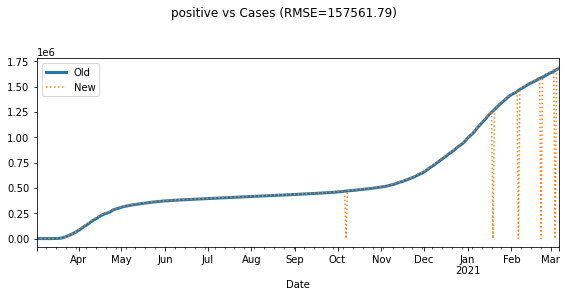




------------------------------------------------------------
inpatient_beds


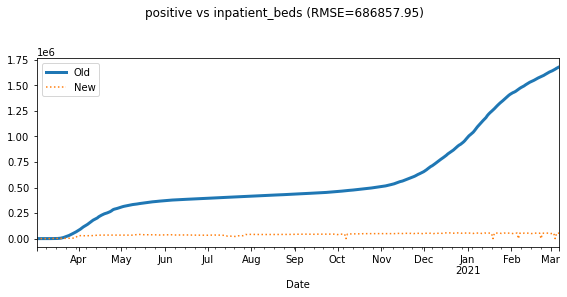




------------------------------------------------------------
inpatient_beds_utilization_denominator


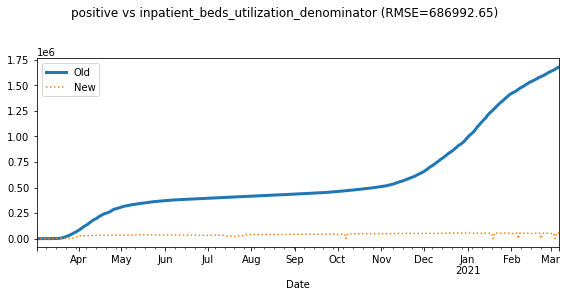

In [43]:
res_positive = compare_old_vs_new_cols(old_state,new_state,old_col='positive')

### Legacy `death` column

,Old Col,New Col,RMSE
0,death,inpatient_beds_utilization_numerator,7646.687159
1,death,percent_of_inpatients_with_covid_denominator,7811.401040
2,death,inpatient_beds_used,7942.281433


------------------------------------------------------------
inpatient_beds_utilization_numerator


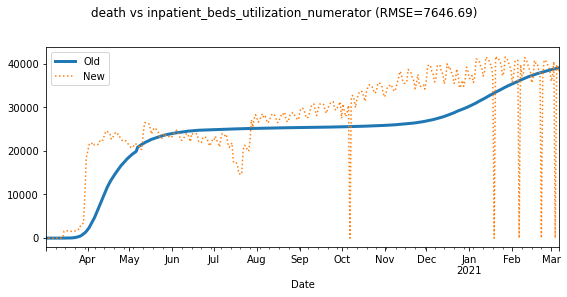




------------------------------------------------------------
percent_of_inpatients_with_covid_denominator


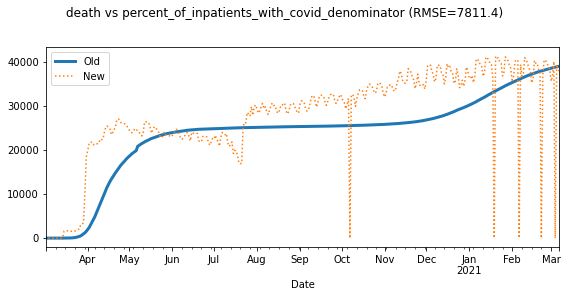




------------------------------------------------------------
inpatient_beds_used


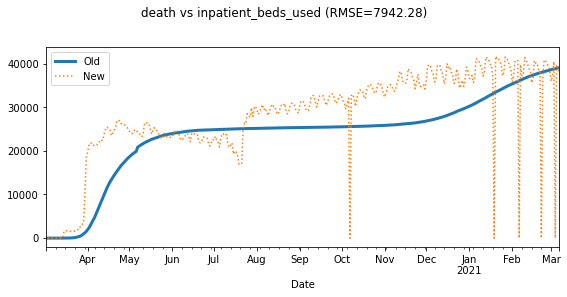

In [44]:
res_positive = compare_old_vs_new_cols(old_state,new_state,old_col='death')

### Legacy  `inIcuCurrently` Column

,Old Col,New Col,RMSE
0,inIcuCurrently,adult_icu_bed_covid_utilization_numerator,1498.790356
1,inIcuCurrently,deaths_covid,1507.592056
2,inIcuCurrently,inpatient_beds_used_covid_coverage,1547.293553


------------------------------------------------------------
adult_icu_bed_covid_utilization_numerator


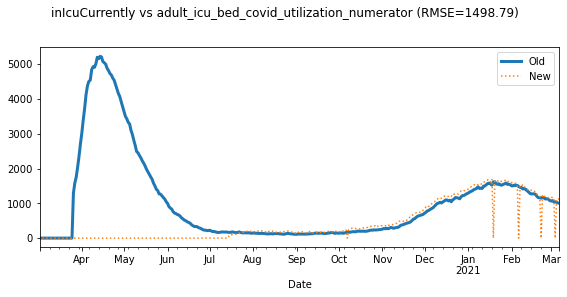




------------------------------------------------------------
deaths_covid


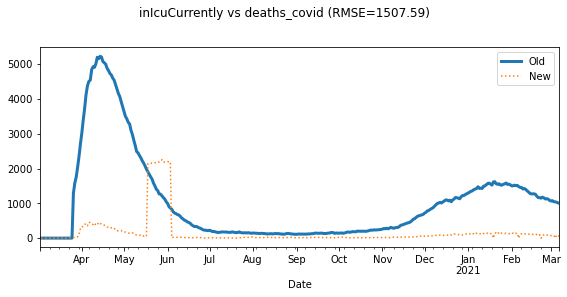




------------------------------------------------------------
inpatient_beds_used_covid_coverage


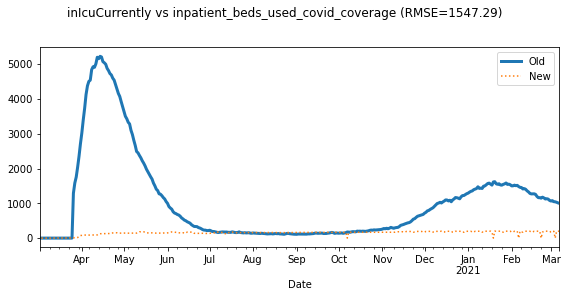

In [45]:
res = compare_old_vs_new_cols(old_state,new_state,old_col='inIcuCurrently')

### Legacy  `hospitalizedCurrently` Column

,Old Col,New Col,RMSE
0,hospitalizedCurrently,percent_of_inpatients_with_covid_numerator,1731.590622
1,hospitalizedCurrently,inpatient_beds_used_covid,1748.073466
2,hospitalizedCurrently,inpatient_bed_covid_utilization_numerator,1811.850704


------------------------------------------------------------
percent_of_inpatients_with_covid_numerator


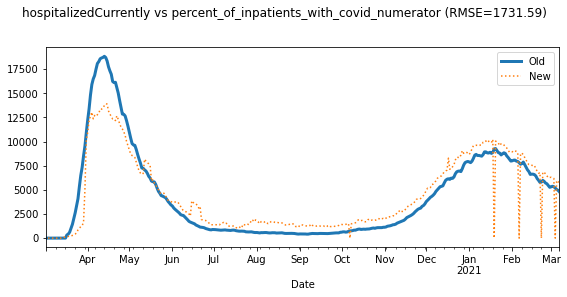




------------------------------------------------------------
inpatient_beds_used_covid


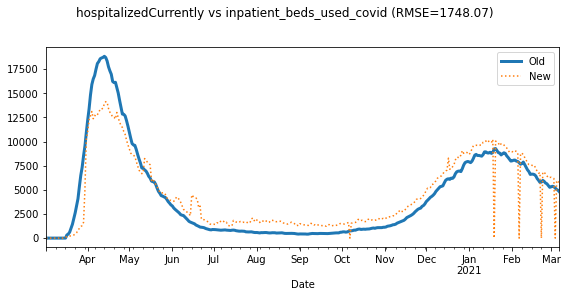




------------------------------------------------------------
inpatient_bed_covid_utilization_numerator


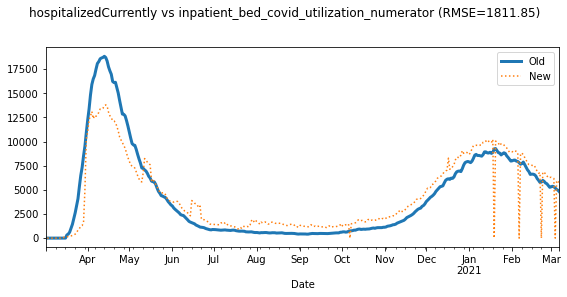

In [46]:
res = compare_old_vs_new_cols(old_state,new_state,old_col='hospitalizedCurrently')

### MATCHING COLUMN MAPPER
- old "`death`"== new "`Deaths`
- old "`positive`"== new "`Cases`
- old "`hospitalizedCurrently`" ==`adult_icu_bed_covid_utilization_numerator`
    
- old "`inIcuCurrently`" == `adult_icu_bed_covid_utilization_numerator`
       

In [47]:
## making mapper dict to rename new columns
new_to_match_old_map = {
    'Deaths':'death',
    'Cases':'positive',
    'total_adult_patients_hospitalized_confirmed_covid':'hospitalizedCurrently',
'adult_icu_bed_covid_utilization_numerator':'inIcuCurrently'}

In [48]:
new_state[list(new_to_match_old_map.keys())]

,Deaths,Cases,total_adult_patients_hospitalized_confirmed_covid,adult_icu_bed_covid_utilization_numerator
Date,,,,
2020-03-14,5,557,NaN,NaN
2020-03-15,10,633,NaN,NaN
2020-03-16,21,961,NaN,NaN
2020-03-17,35,1407,NaN,NaN
2020-03-18,60,2507,NaN,NaN
...,...,...,...,...
2021-03-02,47616,1656684,5507.0,1165.0
2021-03-03,47733,1663248,5466.0,1164.0
2021-03-05,47951,1678867,5206.0,1122.0


In [49]:
old_state[list(new_to_match_old_map.values())]

,death,positive,hospitalizedCurrently,inIcuCurrently
Date,,,,
2021-03-07,39029.0,1681169.0,4789.0,999.0
2021-03-06,38970.0,1674380.0,4954.0,1012.0
2021-03-05,38891.0,1666733.0,5034.0,1030.0
2021-03-04,38796.0,1657777.0,5177.0,1043.0
2021-03-03,38735.0,1650184.0,5323.0,1047.0
...,...,...,...,...
2020-03-06,NaN,25.0,NaN,NaN
2020-03-05,NaN,3.0,NaN,NaN
2020-03-04,NaN,1.0,NaN,NaN


In [50]:
## making mapper dict to rename new columns
new_to_final_names = {
    'Deaths':'Deaths',
    'Cases':'Cases',
    'total_adult_patients_hospitalized_confirmed_covid':'Hospitalized Currently',
'adult_icu_bed_covid_utilization_numerator':'ICU-Covid Currently'}
list(new_to_final_names.keys())

['Deaths',
 'Cases',
 'total_adult_patients_hospitalized_confirmed_covid',
 'adult_icu_bed_covid_utilization_numerator']

## Processing All States Final Data

In [51]:
## saving final version of dataset
FINAL_STATES = {} #pd.DataFrame(index=date_index)

for state, state_df in STATES.items():
    
    state_df = state_df[list(new_to_final_names.keys())].copy().sort_index()
    state_df = state_df.rename(new_to_final_names,axis=1)
    
    ## Renamaed columns to process
    hospital_cols = ['Hospitalized Currently','ICU-Covid Currently']
    cumulative_cols = ['Deaths','Cases'] # cols to diff
    
    ## fill hospital cols with 0
    state_df[hospital_cols] = state_df[hospital_cols].fillna(0)

    for col in cumulative_cols:
        state_df[f"{col}-New"] = state_df[col].diff().fillna(0)
    state_df

#     state_df.columns = [f"{state}: {c}" for c in state_df.columns]
    FINAL_STATES[state]= state_df.copy()


FINAL_STATES.keys()

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

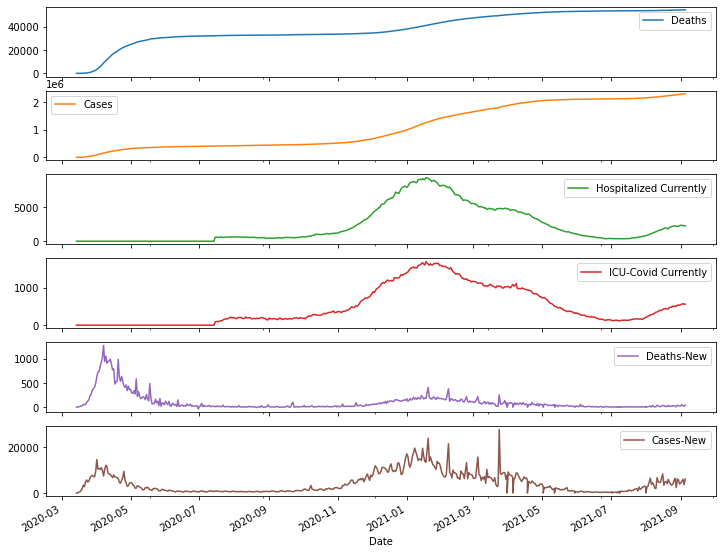

In [52]:
FINAL_STATES['NY'].plot(subplots=True,figsize=(12,10));

In [91]:
## save FINAL_STATES
fpath_final_states = os.path.join(fpath_clean,'FINAL_STATES.joblib')
joblib.dump(FINAL_STATES,fpath_final_states,compress=3)

['./data/FINAL_STATES.joblib']

### Concatenating as Final DataFrame `DF`

In [54]:
DF = pd.concat(FINAL_STATES)
DF

Deaths  Cases  Hospitalized Currently  ICU-Covid Currently  Deaths-New  Cases-New
   Date                                                                                         
AK 2020-03-23       0     39                     0.0                  0.0         0.0        0.0
   2020-03-24       0     43                     0.0                  0.0         0.0        4.0
   2020-03-25       1     50                     0.0                  0.0         1.0        7.0
   2020-03-26       1     64                     0.0                  0.0         0.0       14.0
   2020-03-27       1     75                     0.0                  0.0         0.0       11.0
...               ...    ...                     ...                  ...         ...        ...
WY 2021-09-01     858  76007                   201.0                 57.0         0.0      871.0
   2021-09-02     858  76602                   201.0                 54.0         0.0      595.0
   2021-09-03     858  77206                   188.0                 57.0         0.0      604.0
   2021-09-04     858  77206                   196.0                 61.0         0.0        0.0
   2021-09-05     858  77206                   204.0                 59.0         0.0        0.0

[28900 rows x 6 columns]

In [55]:
## Saving Final Combined DataFrame as both comnpressed csv and pickle
fpath_final_df_csv = os.path.join(fpath_clean,'FINAL_STATES.csv.gz')
fpath_final_df_pickle = fpath_final_df_csv.replace('.csv.gz','.pickle')

DF.to_csv( fpath_final_df_csv,compression='gzip')
print(f"[i] Final joined data (DF) saved as {fpath_final_df_csv}")

DF.to_pickle( fpath_final_df_pickle)
print(f"[i] Final joined data (DF) saved as {fpath_final_df_pickle}")


[i] Final joined data (DF) saved as ./data/FINAL_STATES.csv.gz
[i] Final joined data (DF) saved as ./data/FINAL_STATES.pickle


In [56]:
## testing loading in data
DF = pd.read_csv(fpath_final_df_csv,parse_dates=['Date'],index_col=[0,1])
DF

Deaths  Cases  Hospitalized Currently  ICU-Covid Currently  Deaths-New  Cases-New
   Date                                                                                         
AK 2020-03-23       0     39                     0.0                  0.0         0.0        0.0
   2020-03-24       0     43                     0.0                  0.0         0.0        4.0
   2020-03-25       1     50                     0.0                  0.0         1.0        7.0
   2020-03-26       1     64                     0.0                  0.0         0.0       14.0
   2020-03-27       1     75                     0.0                  0.0         0.0       11.0
...               ...    ...                     ...                  ...         ...        ...
WY 2021-09-01     858  76007                   201.0                 57.0         0.0      871.0
   2021-09-02     858  76602                   201.0                 54.0         0.0      595.0
   2021-09-03     858  77206                   188.0                 57.0         0.0      604.0
   2021-09-04     858  77206                   196.0                 61.0         0.0        0.0
   2021-09-05     858  77206                   204.0                 59.0         0.0        0.0

[28900 rows x 6 columns]

In [57]:
## testing loading in data
DF_pkl = pd.read_pickle(fpath_final_df_pickle)#,parse_dates=['Date'],index_col=[0,1])
DF_pkl

Deaths  Cases  Hospitalized Currently  ICU-Covid Currently  Deaths-New  Cases-New
   Date                                                                                         
AK 2020-03-23       0     39                     0.0                  0.0         0.0        0.0
   2020-03-24       0     43                     0.0                  0.0         0.0        4.0
   2020-03-25       1     50                     0.0                  0.0         1.0        7.0
   2020-03-26       1     64                     0.0                  0.0         0.0       14.0
   2020-03-27       1     75                     0.0                  0.0         0.0       11.0
...               ...    ...                     ...                  ...         ...        ...
WY 2021-09-01     858  76007                   201.0                 57.0         0.0      871.0
   2021-09-02     858  76602                   201.0                 54.0         0.0      595.0
   2021-09-03     858  77206                   188.0                 57.0         0.0      604.0
   2021-09-04     858  77206                   196.0                 61.0         0.0        0.0
   2021-09-05     858  77206                   204.0                 59.0         0.0        0.0

[28900 rows x 6 columns]

In [58]:
DF.loc['MD'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 563 entries, 2020-03-01 to 2021-09-05
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Deaths                  563 non-null    int64  
 1   Cases                   563 non-null    int64  
 2   Hospitalized Currently  563 non-null    float64
 3   ICU-Covid Currently     563 non-null    float64
 4   Deaths-New              563 non-null    float64
 5   Cases-New               563 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 30.8 KB


In [59]:
DF.loc['MD'].index

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
               '2021-08-31', '2021-09-01', '2021-09-02', '2021-09-03',
               '2021-09-04', '2021-09-05'],
              dtype='datetime64[ns]', name='Date', length=563, freq=None)

In [60]:
DF_pkl.loc['MD'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 563 entries, 2020-03-01 to 2021-09-05
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Deaths                  563 non-null    int64  
 1   Cases                   563 non-null    int64  
 2   Hospitalized Currently  563 non-null    float64
 3   ICU-Covid Currently     563 non-null    float64
 4   Deaths-New              563 non-null    float64
 5   Cases-New               563 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 30.8 KB


In [61]:
DF_pkl.loc['MD'].index

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
               '2021-08-31', '2021-09-01', '2021-09-02', '2021-09-03',
               '2021-09-04', '2021-09-05'],
              dtype='datetime64[ns]', name='Date', length=563, freq=None)

# Conclusion (Part 1)

- Our replacement workflow for obtaining state-specific coronavirus data, including hospital capacity, was successful.
- **To Do:**
    - **Consider making FULL_WORKFLOW also do the joins and make FINAL_STATES**

- Now, `2_Covid Time Series Modeling By State.ipynb` for more EDA and time series forecasting/

In [62]:
os.listdir(fpath_clean)

['us_states_daily_cases_deaths.csv',
 'state_data',
 'combined_us_states_full_data.csv',
 'us_states_cases_deaths.csv',
 'STATE_DICT.joblib',
 'FINAL_STATES.joblib',
 'FINAL_STATES.csv.gz',
 'COLUMNS.joblib',
 'FINAL_STATES.pickle']

In [83]:
# [v for v in dir(covid) if not v.startswith('_')]

In [85]:
# locals()

## Saving Final Filepaths for Easy Coordination

In [86]:
name_of_fpath_vars = [v for v in locals() if 'fpath' in v]
name_of_fpath_vars

['fpath_raw',
 'fpath_clean',
 'fpath_reference',
 'fpath_state_data',
 'fpath_final_df_csv',
 'fpath_final_df_pickle',
 'name_of_fpath_vars']

In [ ]:
COLUMNS

In [94]:
## dict of filepaths to save
name_of_fpath_vars = [v for v in locals() if 'fpath' in v]

file_dict = {}
for name in name_of_fpath_vars:
    file_dict[name] = locals()[name]

file_dict

{'fpath_raw': './data_raw/',
 'fpath_clean': './data/',
 'fpath_reference': './reference_data/',
 'fpath_state_data': './data/state_data/',
 'fpath_final_df_csv': './data/FINAL_STATES.csv.gz',
 'fpath_final_df_pickle': './data/FINAL_STATES.pickle',
 'name_of_fpath_vars': ['fpath_raw',
  'fpath_clean',
  'fpath_reference',
  'fpath_state_data',
  'fpath_final_df_csv',
  'fpath_final_df_pickle',
  'name_of_fpath_vars',
  'fpath_final_states'],
 'fpath_final_states': './data/FINAL_STATES.joblib'}

In [95]:
## Saving Final File Directory
import json

with open('FILE_DIRECTORY.json','w') as f:
    json.dump(file_dict,f)